In [45]:
import requests
import os
from fastai.vision.all import *

from duckduckgo_search import DDGS

base_path="data"
tmp_path='tmp'

os.makedirs(base_path, exist_ok=True)

def get_images(keywords, count):
    results = DDGS().images(
        keywords=keywords,
        max_results=count,
    )
    image_urls = [result['image'] for result in results]  # List comprehension
    return image_urls

In [46]:
# download dogs images
dogs = get_images("dogs and puppies", 50)
download_images(f"{base_path}/dogs", null, dogs)

In [47]:
# download cats images
cats = get_images("cats and kittens", 50)
all = [*cats, *kittens]
download_images(f"{base_path}/cats", null, all)

In [48]:
# resize images
resize_images(f"{base_path}/dogs", max_size=400, dest=f"{base_path}/dogs")
resize_images(f"{base_path}/cats", max_size=400, dest=f"{base_path}/cats")

In [53]:
#remove failed images
failed = verify_images(get_image_files(base_path))
failed.map(Path.unlink)
print(len(failed))

0


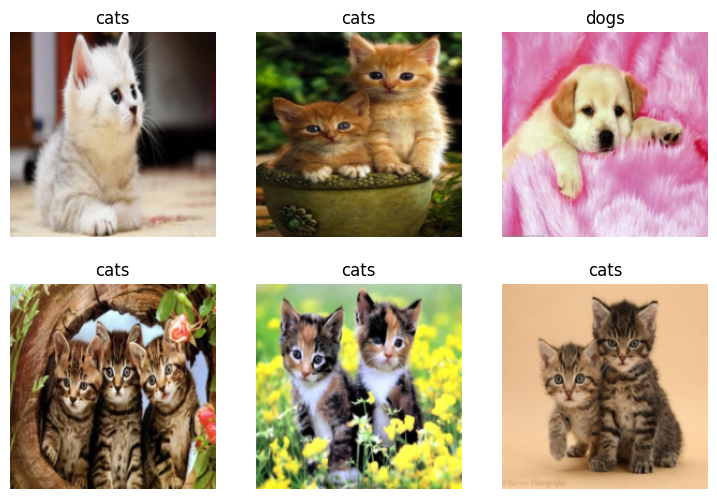

In [54]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(base_path, bs=32)

dls.show_batch(max_n=6)

epoch,train_loss,valid_loss,error_rate,time
0,1.282695,0.326433,0.147059,00:00
1,0.849551,0.049063,0.000000,00:00
2,0.610988,0.015739,0.000000,00:00
3,0.452739,0.012776,0.000000,00:00
4,0.360929,0.018441,0.000000,00:00
5,0.335938,0.021413,0.000000,00:00
6,0.290579,0.018584,0.000000,00:00
7,0.246140,0.013636,0.000000,00:00
8,0.211247,0.016063,0.000000,00:00
9,0.189121,0.016829,0.000000,00:00


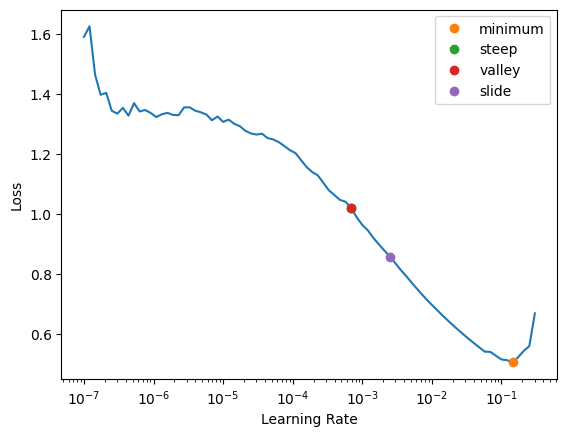

In [63]:
learn = vision_learner(dls, resnet18, metrics=error_rate) #using resnet18 pretrained model

lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
learn.fit_one_cycle(3,slice(lrs.minimum,lrs.slide))

In [56]:
# prepare test data
def copy_and_rename_images(source_folder, destination_folder):
    source_path = Path(source_folder)
    destination_path = Path(destination_folder)
    
    # Create destination folder if it does not exist
    destination_path.mkdir(parents=True, exist_ok=True)
    
    # Get all image files including those in subfolders
    image_files = get_image_files(source_path)
    
    # Copy and rename images
    for i, file in enumerate(image_files):
        parent_folder_name = file.parent.name
        new_filename = f"{parent_folder_name}_{i+1}{file.suffix}"
        shutil.copy(file, destination_path / new_filename)

copy_and_rename_images(base_path, tmp_path) # copy files to tmp folder

In [65]:
randoms = get_files(tmp_path)  # Assuming this returns a list of Image objects

for image in randoms:
    label_prediction, _, probs = learn.predict(image) 
    if label_prediction not in str(image): 
        print(f"Label: {label_prediction}. Filename: {image}") 
